# BDA Final Project Sentiment Analysis Models

#### We will train a supervised training model to predict if a tweet has a positive or negative sentiment.

#### Dataset loading & dev/test splits

1) Load the twitter dataset from NLTK library

In [ ]:
import numpy as np
import pandas as pd
import nltk
nltk.download('twitter_samples')
nltk.download('punkt')
from nltk.corpus import twitter_samples 

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


2) Load the positive & negative tweets. Use tweets as dataset to train models.

In [ ]:
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

3) Create a development & test split (80/20 ratio):

In [ ]:
#code here
positive_dict = pd.DataFrame({'tweet': all_positive_tweets, 'sentiment': 'positive'})
negative_dict = pd.DataFrame({'tweet': all_negative_tweets, 'sentiment': 'negative'})
tweets = positive_dict.append(negative_dict, ignore_index = True)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tweets['tweet'], 
                                                    tweets['sentiment'], 
                                                    stratify = tweets['sentiment'],
                                                    test_size = 0.2, 
                                                    random_state = 1)

#### Data preprocessing

We will do some data preprocessing before we tokenize the data. We will remove `#` symbol, hyperlinks, stop words & punctuations from the data. You can use the `re` package in python to find and replace these strings. 

In [ ]:
import re

1) Replace the `#` symbol with '' in every tweet

In [ ]:
#code here
def remove_hashtags(dataset):
    processed_dataset = []
    for i, tweet in enumerate(dataset):
        processed_dataset.append(re.sub(r'#[A-Za-z0-9_]+', '', tweet))
    return processed_dataset

X_train = pd.Series(remove_hashtags(X_train))
X_test = pd.Series(remove_hashtags(X_test))

In [ ]:
print(X_train.shape, X_test.shape)

(8000,) (2000,)


2) Replace hyperlinks with '' in every tweet

In [ ]:
#code here
def remove_hyperlinks(dataset):
    processed_dataset = []
    for i, tweet in enumerate(dataset):
        processed_dataset.append(re.sub(r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', r'', tweet))
    return processed_dataset

X_train = pd.Series(remove_hyperlinks(X_train))
X_test = pd.Series(remove_hyperlinks(X_test))

In [ ]:
print(X_train.shape, X_test.shape)

(8000,) (2000,)


3) Remove all stop words

In [ ]:
#code here
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

def remove_stopwords(dataset):
    processed_dataset = []
    stop_words = set(stopwords.words('english'))
    for i, tweet in enumerate(dataset):
        tweet_tokens = word_tokenize(tweet)
        filtered_tweet_tokens = [w for w in tweet_tokens if not w.lower() in stop_words]
        processed_dataset.append(' '.join(filtered_tweet_tokens))
    return processed_dataset

X_train = pd.Series(remove_stopwords(X_train))
X_test = pd.Series(remove_stopwords(X_test))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(X_train.shape, X_test.shape)

(8000,) (2000,)


4) Remove all punctuations

In [ ]:
#code here
def remove_punctuations(dataset):
    processed_dataset = []
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for i, tweet in enumerate(dataset):
        for element in tweet:
            if element in punc:
                tweet = tweet.replace(element, '')
        processed_dataset.append(tweet)
    return processed_dataset

X_train = pd.Series(remove_punctuations(X_train))
X_test = pd.Series(remove_punctuations(X_test))

In [ ]:
print(X_train.shape, X_test.shape)

(8000,) (2000,)


5) Apply stemming on the development & test datasets using Porter algorithm

In [ ]:
#code here
from nltk.stem import PorterStemmer
porter = PorterStemmer()

def porter_stemming(dataset):
    processed_dataset = []
    for i, tweet in enumerate(dataset):
        tweet_tokens = word_tokenize(tweet)
        stemmed_tweet_tokens = [porter.stem(w) for w in tweet_tokens]
        processed_dataset.append(' '.join(stemmed_tweet_tokens))
    return processed_dataset

X_train = pd.Series(porter_stemming(X_train))
X_test = pd.Series(porter_stemming(X_test))

In [ ]:
print(X_train.shape, X_test.shape)

(8000,) (2000,)


#### Model training

##### Logistic Regression

BOW Approach

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

pipe_lr_bow = Pipeline([
                         ('cv', CountVectorizer()),
                         ('lr', LogisticRegression(penalty = 'elasticnet', C = 1, solver = 'saga'))
])

print(pipe_lr_bow)

param_grid = {'lr__l1_ratio': [round(x*0.1, 2) for x in range(0, 11, 2)],
              'lr__C': [100, 10, 1.0, 0.1, 0.01]}

rs_pipe_lr_bow = RandomizedSearchCV(pipe_lr_bow, param_grid, n_jobs = -1).fit(X_train, y_train)

bow_score = rs_pipe_lr_bow.score(X_test, y_test)

print('The score on the testing set with the bag of words approach is {:.2f}'.format(bow_score))
print('The best hyperparameters are: {}'.format(rs_pipe_lr_bow.best_params_))

Pipeline(steps=[('cv', CountVectorizer()),
                ('lr',
                 LogisticRegression(C=1, penalty='elasticnet', solver='saga'))])
The score on the testing set with the bag of words approach is 0.74
The best hyperparameters are: {'lr__l1_ratio': 0.4, 'lr__C': 10}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


TFIDF Approach

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

pipe_lr_tfidf = Pipeline([
                         ('tfidf', TfidfVectorizer()),
                         ('lr', LogisticRegression(penalty = 'elasticnet', C = 1, solver = 'saga'))
])

print(pipe_lr_tfidf)

param_grid = {'lr__l1_ratio': [round(x*0.1, 2) for x in range(0, 11, 2)],
              'lr__C': [100, 10, 1.0, 0.1, 0.01]}

rs_pipe_lr_tfidf = RandomizedSearchCV(pipe_lr_tfidf, param_grid, n_jobs = -1).fit(X_train, y_train)

tfidf_score = rs_pipe_lr_tfidf.score(X_test, y_test)

print('The score on the testing set with the TFIDF approach is {:.2f}'.format(tfidf_score))
print('The best hyperparameters are: {}'.format(rs_pipe_lr_tfidf.best_params_))

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('lr',
                 LogisticRegression(C=1, penalty='elasticnet', solver='saga'))])
The score on the testing set with the TFIDF approach is 0.74
The best hyperparameters are: {'lr__l1_ratio': 0.0, 'lr__C': 10}


GloVe Approach

In [ ]:
from sklearn.pipeline import Pipeline
from zeugma.embeddings import EmbeddingTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

pipe_lr_g = Pipeline([
                          ('glove', EmbeddingTransformer('glove')),
                          ('lr', LogisticRegression(penalty = 'elasticnet', solver = 'saga'))
])

print(pipe_lr_g)

Pipeline(steps=[('glove',
                 EmbeddingTransformer(model=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x7fa6723c4910>)),
                ('lr',
                 LogisticRegression(penalty='elasticnet', solver='saga'))])


##### Support Vector Classifier

BOW Approach

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

pipe_svc_bow = Pipeline([
                         ('cv', CountVectorizer(min_df = 0)),
                         ('svc', SVC(kernel = 'rbf'))
])

print(pipe_svc_bow)

param_grid = {'cv__max_df': [round(x*0.1, 2) for x in range(1, 11, 2)],
              'svc__C': np.logspace(-3, 3, 5),
              'svc__gamma': np.logspace(-3, 1, 5)}

gs_pipe_svc_bow = GridSearchCV(pipe_svc_bow, param_grid, cv = 2, n_jobs = -1).fit(X_train, y_train)

bow_score = gs_pipe_svc_bow.score(X_test, y_test)

print('The score on the testing set with the bag of words approach is {:.2f}'.format(bow_score))
print('The best hyperparameters are: {}'.format(gs_pipe_svc_bow.best_params_))

Pipeline(steps=[('cv', CountVectorizer(min_df=0)), ('svc', SVC())])
The score on the testing set with the bag of words approach is 0.74
The best hyperparameters are: {'cv__max_df': 0.1, 'svc__C': 31.622776601683793, 'svc__gamma': 0.01}


TFIDF Approach

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

pipe_svc_tfidf = Pipeline([
                         ('tfidf', TfidfVectorizer(min_df = 0)),
                         ('svc', SVC(kernel = 'rbf'))
])

print(pipe_svc_tfidf)

param_grid = {'tfidf__max_df': [round(x*0.1, 2) for x in range(1, 11, 2)],
              'svc__C': np.logspace(-3, 3, 5),
              'svc__gamma': np.logspace(-3, 1, 5)}

gs_pipe_svc_tfidf = GridSearchCV(pipe_svc_tfidf, param_grid, cv = 2, n_jobs = -1).fit(X_train, y_train)

tfidf_score = gs_pipe_svc_tfidf.score(X_test, y_test)

print('The score on the testing set with the TFIDF approach is {:.2f}'.format(tfidf_score))
print('The best hyperparameters are: {}'.format(gs_pipe_svc_tfidf.best_params_))

Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=0)), ('svc', SVC())])
The score on the testing set with the TFIDF approach is 0.76
The best hyperparameters are: {'svc__C': 1.0, 'svc__gamma': 1.0, 'tfidf__max_df': 0.1}


##### Random Forest Classifier

BOW Approach

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

pipe_rf_bow = Pipeline([
                         ('cv', CountVectorizer(min_df = 0)),
                         ('rf', RandomForestClassifier(n_estimators = 200))
])

print(pipe_rf_bow)

param_grid = {'cv__max_df': [round(x*0.1, 2) for x in range(1, 11)],
              'rf__max_depth': [x for x in range(3, 11)]}

gs_pipe_rf_bow = GridSearchCV(pipe_rf_bow, param_grid, cv = 2, n_jobs = -1).fit(X_train, y_train)

bow_score = gs_pipe_rf_bow.score(X_test, y_test)

print('The score on the testing set with the bag of words approach is {:.2f}'.format(bow_score))
print('The best hyperparameters are: {}'.format(gs_pipe_rf_bow.best_params_))

Pipeline(steps=[('cv', CountVectorizer(min_df=0)),
                ('rf', RandomForestClassifier(n_estimators=200))])
The score on the testing set with the bag of words approach is 0.72
The best hyperparameters are: {'cv__max_df': 0.2, 'rf__max_depth': 9}


TFIDF Approach

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

pipe_rf_tfidf = Pipeline([
                         ('tfidf', TfidfVectorizer(min_df = 0)),
                         ('rf', RandomForestClassifier(n_estimators = 200))
])

print(pipe_rf_tfidf)
     
param_grid = {'tfidf__max_df': [round(x*0.1, 2) for x in range(1, 11)],
              'rf__max_depth': [x for x in range(3, 11)]}

gs_pipe_rf_tfidf = GridSearchCV(pipe_rf_tfidf, param_grid, cv = 2, n_jobs = -1).fit(X_train, y_train)

tfidf_score = gs_pipe_rf_tfidf.score(X_test, y_test)

print('The score on the testing set with the TFIDF approach is {:.2f}'.format(tfidf_score))
print('The best hyperparameters are: {}'.format(gs_pipe_rf_tfidf.best_params_))

Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=0)),
                ('rf', RandomForestClassifier(n_estimators=200))])
The score on the testing set with the TFIDF approach is 0.72
The best hyperparameters are: {'rf__max_depth': 8, 'tfidf__max_df': 0.9}


##### Gradient Boosting Classifier

BOW Approach

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

pipe_gbc_bow = Pipeline([
                         ('cv', CountVectorizer(min_df = 0)),
                         ('gbc', GradientBoostingClassifier(n_estimators = 200))
])

print(pipe_gbc_bow)

param_grid = {'cv__max_df': [round(x*0.1, 2) for x in range(1, 11)],
              'gbc__max_depth': [x for x in range(3, 11)]}

gs_pipe_gbc_bow = GridSearchCV(pipe_gbc_bow, param_grid, cv = 2, n_jobs = -1).fit(X_train, y_train)

bow_score = gs_pipe_gbc_bow.score(X_test, y_test)

print('The score on the testing set with the bag of words approach is {:.2f}'.format(bow_score))
print('The best hyperparameters are: {}'.format(gs_pipe_gbc_bow.best_params_))

Pipeline(steps=[('cv', CountVectorizer(min_df=0)),
                ('gbc', GradientBoostingClassifier(n_estimators=200))])
The score on the testing set with the bag of words approach is 0.74
The best hyperparameters are: {'cv__max_df': 0.1, 'gbc__max_depth': 9}


TFIDF Approach

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

pipe_gbc_tfidf = Pipeline([
                         ('tfidf', TfidfVectorizer(min_df = 0)),
                         ('gbc', GradientBoostingClassifier(n_estimators = 200))
])

print(pipe_gbc_tfidf)

param_grid = {'tfidf__max_df': [round(x*0.1, 2) for x in range(1, 11)],
              'gbc__max_depth': [x for x in range(3, 11)]}

gs_pipe_gbc_tfidf = GridSearchCV(pipe_gbc_tfidf, param_grid, cv = 2, n_jobs = -1).fit(X_train, y_train)

tfidf_score = gs_pipe_gbc_tfidf.score(X_test, y_test)

print('The score on the testing set with the TFIDf approach is {:.2f}'.format(tfidf_score))
print('The best hyperparameters are: {}'.format(gs_pipe_gbc_tfidf.best_params_))

Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=0)),
                ('gbc', GradientBoostingClassifier(n_estimators=200))])
The score on the testing set with the TFIDf approach is 0.73
The best hyperparameters are: {'gbc__max_depth': 10, 'tfidf__max_df': 0.9}


##### XGBoost Classifier

BOW Approach

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

pipe_xgb_bow = Pipeline([
                         ('cv', CountVectorizer(min_df = 0)),
                         ('xgb', XGBClassifier(n_estimators = 200))
])

print(pipe_xgb_bow)

param_grid = {'cv__max_df': [round(x*0.1, 2) for x in range(1, 11, 2)],
              'xgb__max_depth': [x for x in range(3, 11)]}

gs_pipe_xgb_bow = GridSearchCV(pipe_xgb_bow, param_grid, cv = 2, n_jobs = -1).fit(X_train, y_train)

bow_score = gs_pipe_xgb_bow.score(X_test, y_test)

print('The score on the testing set with the bag of words approach is {:.2f}'.format(bow_score))
print('The best hyperparameters are: {}'.format(gs_pipe_xgb_bow.best_params_))

Pipeline(steps=[('cv', CountVectorizer(min_df=0)),
                ('xgb', XGBClassifier(n_estimators=200))])
The score on the testing set with the bag of words approach is 0.73
The best hyperparameters are: {'cv__max_df': 0.1, 'xgb__max_depth': 9}


TFIDF Approach

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

pipe_xgb_tfidf = Pipeline([
                         ('tfidf', TfidfVectorizer(min_df = 0)),
                         ('xgb', XGBClassifier(n_estimators = 200))
])

print(pipe_xgb_tfidf)

param_grid = {'tfidf__max_df': [round(x*0.1, 2) for x in range(1, 11, 2)],
              'xgb__max_depth': [x for x in range(3, 11)]}

gs_pipe_xgb_tfidf = GridSearchCV(pipe_xgb_tfidf, param_grid, cv = 2, n_jobs = -1).fit(X_train, y_train)

tfidf_score = gs_pipe_xgb_tfidf.score(X_test, y_test)

print('The score on the testing set with the bag of words approach is {:.2f}'.format(tfidf_score))
print('The best hyperparameters are: {}'.format(gs_pipe_xgb_tfidf.best_params_))

Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=0)),
                ('xgb', XGBClassifier(n_estimators=200))])
The score on the testing set with the bag of words approach is 0.72
The best hyperparameters are: {'tfidf__max_df': 0.1, 'xgb__max_depth': 7}


#### Predicting on Streaming Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
streamed_file = '/content/gdrive/My Drive/Fall 2021/EECS6895-BDA/Final Project/project_tweets'
streamed_tweets = pd.read_csv(streamed_file)
streamed_tweets = streamed_tweets.rename(columns = {'_c0': 'Tweet'})
streamed_tweets = pd.Series(streamed_tweets['Tweet'])

In [ ]:
len(streamed_tweets)

12214

In [ ]:
streamed_tweets[20]

'Limits and Opportunities'

In [ ]:
def remove_nonascii(dataset):
  processed_dataset = []
  for i, tweet in enumerate(dataset):
      encoded_tweet = tweet.encode('ascii', 'ignore')
      processed_dataset.append(encoded_tweet.decode())
  return processed_dataset

In [ ]:
def preprocess(dataset):
  dataset = pd.Series(remove_nonascii(dataset))
  dataset = pd.Series(remove_hashtags(dataset))
  dataset = pd.Series(remove_hyperlinks(dataset))
  dataset = pd.Series(remove_stopwords(dataset))
  dataset = pd.Series(remove_punctuations(dataset))
  dataset = pd.Series(porter_stemming(dataset))
  return dataset



In [ ]:
streamed_tweets = preprocess(streamed_tweets)
streamed_tweets

0        animan s newest movi idea well someon nt read ...
1        proud field ipc foundat error droplet transmil...
2        via ingliguori dsanalyt best affirm credit rat...
3                                                     read
4         sonumonika s respons decis make promot trust amp
                               ...                        
12209                                              tidelin
12210                                          primavera 2
12211                                              23iphon
12212                       son ihlal kararlar bir bI love
12213                              katyazamo want dune ass
Length: 12214, dtype: object

In [ ]:
streamed_tweets[20]

'limit opportun'

Visualize Results

In [ ]:
models = ['Logistic Regression',
          'Logistic Regression',
          'Support Vector Classifier', 
          'Support Vector Classifier', 
          'Random Forest Classifier', 
          'Random Forest Classifier', 
          'Gradient Boosting Classifier', 
          'Gradient Boosting Classifier', 
          'XGBoost Classifier', 
          'XGBoost Classifier']

score = [0.74, 0.74, 
         0.74, 0.76, 
         0.72, 0.72, 
         0.74, 0.73, 
         0.73, 0.72]

method = ['bag-of-words', 'tfidf', 
          'bag-of-words', 'tfidf', 
          'bag-of-words', 'tfidf', 
          'bag-of-words', 'tfidf', 
          'bag-of-words', 'tfidf']

df = pd.DataFrame({'models': models, 'score': score, 'method': method})
df

,models,score,method
0,Logistic Regression,0.74,bag-of-words
1,Logistic Regression,0.74,tfidf
2,Support Vector Classifier,0.74,bag-of-words
3,Support Vector Classifier,0.76,tfidf
4,Random Forest Classifier,0.72,bag-of-words
5,Random Forest Classifier,0.72,tfidf
6,Gradient Boosting Classifier,0.74,bag-of-words
7,Gradient Boosting Classifier,0.73,tfidf
8,XGBoost Classifier,0.73,bag-of-words
9,XGBoost Classifier,0.72,tfidf


(0.68, 0.78)

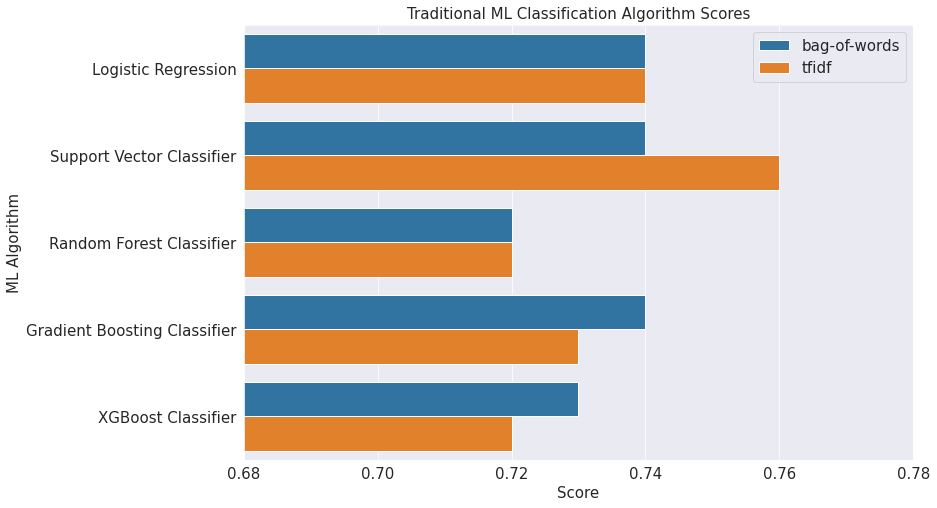

In [ ]:
plt.figure(figsize = (12, 8))
figure = sns.barplot(x = score, y = models, hue = method, data = df)
plt.title('Traditional ML Classification Algorithm Scores', fontsize = 15)
plt.ylabel('ML Algorithm', fontsize = 15)
plt.xlabel('Score', fontsize = 15)
plt.tick_params(labelsize = 15)
plt.legend(fontsize = 15)
ax = figure.axes
ax.set_xlim(.68, .78)